# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [352]:
DATA_FOLDER = 'Data' # Use the data folder provided in Tutorial 02 - Intro to Pandas.

## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average per month* of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

In [353]:
# Write your answer here

## Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

In [354]:
# Write your answer here

## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [355]:
from IPython.core.display import HTML
HTML(filename=DATA_FOLDER+'/titanic.html')

Name,Labels,Units,Levels,Storage,NAs
pclass,,,3,integer,0
survived,Survived,,,double,0
name,Name,,,character,0
sex,,,2,integer,0
age,Age,Year,,double,263
sibsp,Number of Siblings/Spouses Aboard,,,double,0
parch,Number of Parents/Children Aboard,,,double,0
ticket,Ticket Number,,,character,0
fare,Passenger Fare,British Pound (\243),,double,1
cabin,,,187,integer,0


In [356]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_excel(DATA_FOLDER+'/titanic.xls', sheetname='titanic', header=0)

## For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

### Task 3.1 

In [357]:
# Question: Describe the type and the value range of each attribute. 

# We assume that we can describe the value range of each attribute
# only if it's a numerical type

types = df.dtypes
value_range = df._get_numeric_data().apply(lambda x: (x.min(), x.max()))

types.index.name = 'Attribute'
types.columns = 'Type'

value_range.index.name = 'Attribute'
value_range.columns = 'Range'

res = pd.concat(dict(Range=value_range, Type=types), axis=1).fillna('-')
res



,Range,Type
age,"(0.1667, 80.0)",float64
boat,-,object
body,"(1.0, 328.0)",float64
cabin,-,object
embarked,-,object
fare,"(0.0, 512.3292)",float64
home.dest,-,object
name,-,object
parch,"(0.0, 9.0)",int64
pclass,"(1.0, 3.0)",int64


In [358]:
# Question: Indicate and transform the attributes that can be Categorical.

# By visual inspection we can argue that the following columns could be
# categorical : 'pclass', 'survived', 'sex', 'sibsp', 'parch', 'embarked'
#
# We assumed that for an attribute to be categorical it should have 
# <= 10 distinct elements. (NaN is not considered as a distinct value)



categories = pd.Series([v for v in df.columns if len(df[v].unique()) < 10 ])

print('Attributes to be made Categorical:\n\n', categories)
for i in categories:
    df[i] = df[i].astype('category')

Attributes to be made Categorical:

 0      pclass
1    survived
2         sex
3       sibsp
4       parch
5    embarked
dtype: object


### Task 3.2

1309

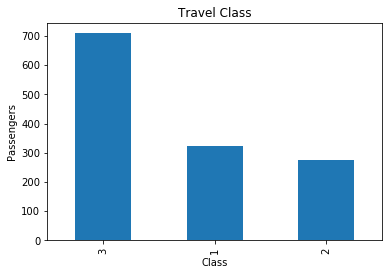

In [359]:
# Question: Plot a histogram for the travel class attribute
%matplotlib inline


hist_plot = df.pclass.value_counts().plot(kind='bar')
hist_plot.set_title('Travel Class')
hist_plot.set_xlabel('Class')
hist_plot.set_ylabel('Passengers')
np.sum(df.pclass.value_counts())


1307

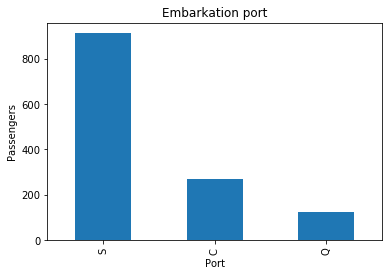

In [360]:
# Question: Plot a histogram for the embarkation port attribute
%matplotlib inline

nb_ports = df['embarked'].describe()['unique']
df.embarked.unique()

hist_plot = df.embarked.value_counts().plot(kind='bar')
hist_plot.set_title('Embarkation port')
hist_plot.set_xlabel('Port')
hist_plot.set_ylabel('Passengers')
sum(df.embarked.value_counts())

1309

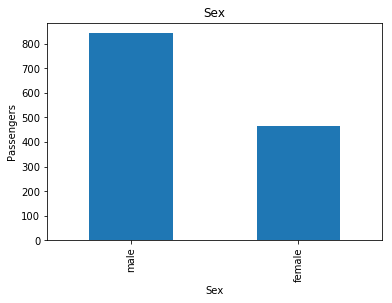

In [361]:
# Question: Plot a histogram for the sex attribute
%matplotlib inline

hist_plot = df.sex.value_counts().plot(kind='bar')
hist_plot.set_title('Sex')
hist_plot.set_xlabel('Sex')
hist_plot.set_ylabel('Passengers')
np.sum(df.sex.value_counts())

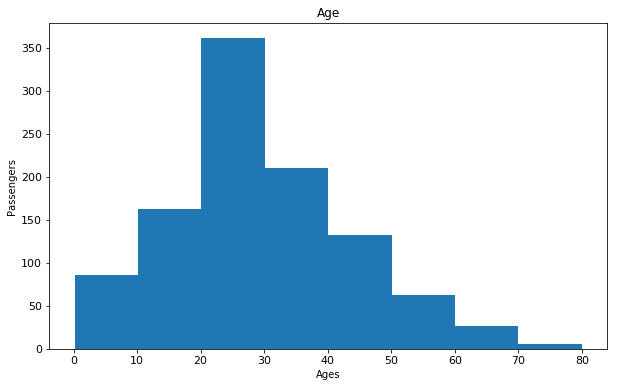

In [362]:
# Question: Plot a histogram for the age attribute


nb_bins = np.ceil(df.age.max()/10).astype('int')
hist_plot = df.age.hist(bins=nb_bins, grid=False, xlabelsize=11, ylabelsize=11, figsize=(10, 6))
hist_plot.set_title('Age')
hist_plot.set_xlabel('Ages')
hist_plot.set_ylabel('Passengers')

### Task 3.3

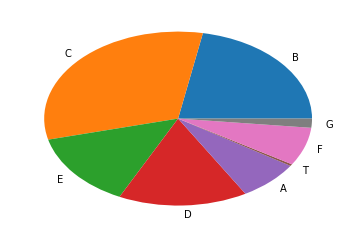

In [363]:
# Question: Calculate the proportion of passengers by cabin floor. 
# Present your results in a pie chart.

# We assumed that the information on the cabin floor is available 
# in the column 'cabin' where the letter indicates the floor.
# the number that follows indicates a specific cabin on that floor.

# Unfortunately, this column is also filled with NaN's values.
# For this statistic we won't try guessing the cabin floor for 
# passenger where the data is not provided. Our analysis relies
# only on values that are already in the dataset.

tot = df.cabin.describe()['count']

temp = df.cabin.dropna(axis=0).apply(lambda x: str(x)[:1])

D = {}
for v in temp:
    if not v in D:
        D[v] = 1
    else:
        D[v] += 1


labels = list(D.keys())
values = list(D.values())


plt.pie(values, labels=labels)
plt.show()


### Task 3.4

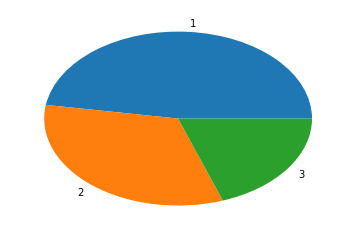

In [364]:
# Question: For each travel class, calculate the proportion of the
# passengers that survived. Present your results in pie charts.

# The pie chart represents only passengers that survived. Each region
# on the chart is the proportion of the passengers in the class
# that survived among all survivors.


tot = df.survived.describe()['count']

class_tot = (df.groupby('pclass').survived.describe())['count']
pclass_survived = df.groupby(['pclass', 'survived']).survived.describe()
pclass_survived = (pclass_survived[pclass_survived['top'] == 1])['freq']
pclass_survived = pclass_survived.reset_index('survived').drop('survived', axis=1)
stats = pd.concat([class_tot, pclass_survived], axis=1)
prop = (stats['freq'] / stats['count'])*100

l = df.set_index('pclass').index.categories
plt.pie(list(prop), labels=list(l))
plt.show()


### Task 3.5

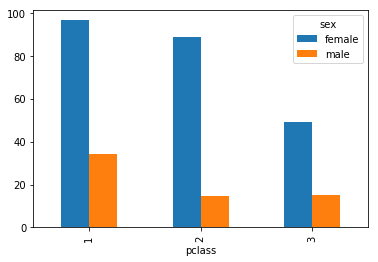

In [365]:
# Question: Calculate the proportion of the passengers that survived 
# by travel class and sex. Present your results in a single histogram.

class_tot = (df.groupby(['pclass', 'sex']).survived.describe())['count']
survived = df.groupby(['pclass', 'sex', 'survived']).survived.describe()
survived = (survived[survived['top'] == 1])['freq']
survived = survived.reset_index('survived').drop('survived', axis=1)
stats = pd.concat([class_tot, survived], axis=1)
prop = (stats['freq'] / stats['count'])*100

prop.unstack(level=1).plot(kind='bar', subplots=False)

### Task 3.6

In [366]:
# Question: Create 2 equally populated age categories and calculate 
# survival proportions by age category, travel class and sex. Present
# your results in a DataFrame with unique index.

# Our analysis is based only on passengers that have a valid 'age'
# field. The field is considered valid only if the value is not a NaN.
# For this statistic we won't try guessing the passenger age when 
# the data is not provided.

# We create our 2 equally populated categories as follow:
# 1. We order the passengers by age in ascending order
# 2. We drop from the table passengers with invalid 'age' value
# 3. We separate the resulting dataframe in two with the cut
#    point being half way down the table

# The stats are then computed for each age category separately before 
# concatenating both resulting tables

# 1.
df.sort_values(['age'], axis=0, inplace=True)
# 2.
df.age.dropna(axis=0, inplace=True)
# 3.
mid = int(np.floor(len(df)/2))
cat1 = df[:mid]
cat2 = df[mid:]


In [367]:
# Survival proportions by age category, travel class and sex
# Age Category #1

class_tot = (cat1.groupby(['age', 'pclass', 'sex']).survived.describe())['count']
survived = cat1.groupby(['age', 'pclass', 'sex', 'survived']).survived.describe()
survived = (survived[survived['top'] == 1])['freq']
survived = survived.reset_index('survived').drop('survived', axis=1)
stats = pd.concat([class_tot, survived], axis=1).fillna(0)
stats.columns = ['total', 'survivors']

s1 = stats.groupby(['pclass', 'sex']).sum()

s1['age'] = 'Younger'
s1.set_index('age', append=True, inplace=True)
s1 = s1.reorder_levels(['age', 'pclass', 'sex'])
s1

total  survivors
age     pclass sex                     
Younger 1      female     53       51.0
               male       45       21.0
        2      female     70       63.0
               male       98       20.0
        3      female    124       61.0
               male      264       53.0

In [368]:
# Survival proportions by age category, travel class and sex
# Age Category #2

class_tot = (cat2.groupby(['age', 'pclass', 'sex']).survived.describe())['count']
survived = cat2.groupby(['age', 'pclass', 'sex', 'survived']).survived.describe()
survived = (survived[survived['top'] == 1])['freq']
survived = survived.reset_index('survived').drop('survived', axis=1)
stats = pd.concat([class_tot, survived], axis=1).fillna(0)
stats.columns = ['total', 'survivors']

s2 = stats.groupby(['pclass', 'sex']).sum()

s2['age'] = 'Older'
s2.set_index('age', append=True, inplace=True)
s2 = s2.reorder_levels(['age', 'pclass', 'sex'])
s2

total  survivors
age   pclass sex                     
Older 1      female     80       77.0
             male      106       32.0
      2      female     33       29.0
             male       60        3.0
      3      female     28       11.0
             male       85        6.0

In [369]:
# Survival proportions by age category, travel class and sex
df = pd.concat([s1, s2], axis=0)
df['proportion'] = (df['survivors'] / df['total'])*100

df

total  survivors  proportion
age     pclass sex                                 
Younger 1      female     53       51.0   96.226415
               male       45       21.0   46.666667
        2      female     70       63.0   90.000000
               male       98       20.0   20.408163
        3      female    124       61.0   49.193548
               male      264       53.0   20.075758
Older   1      female     80       77.0   96.250000
               male      106       32.0   30.188679
        2      female     33       29.0   87.878788
               male       60        3.0    5.000000
        3      female     28       11.0   39.285714
               male       85        6.0    7.058824